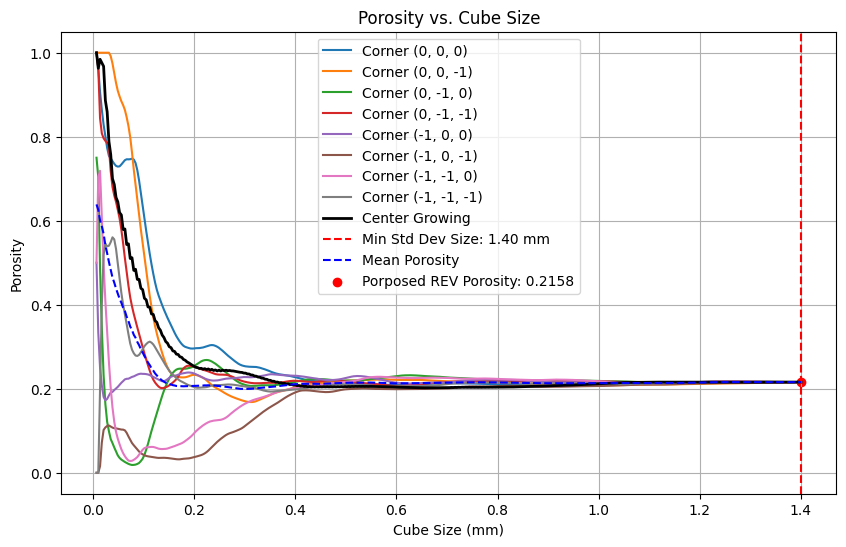

In [1]:
# Center-Corner Cubes Growing algorithm © 2023 by Rail Kadyrov is licensed under CC BY-NC-ND 4.0
# Сite this work: Kadyrov, R.I., 2023. Multiple cubes growth algorithms for simple REV determination on 3D binary images. Scientific Visualization.

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from glob import glob

# Load the 3D binary image stack
folder_path = "C:/Users/.../"
file_extension = "*.tif"  # Change this to "*.png" if using PNG image stacks

# Set the voxel size in mm
voxel_size = 0.001

# Get the paths of all image files in the folder
image_paths = glob(folder_path + file_extension)

# Read the image files and stack them
image_stack = np.stack([io.imread(image_path) for image_path in image_paths])

# Set plot zoom range limits by limiting the cube sizes (in voxels)
zoom_from = 2
zoom_to = min(image_stack.shape)     #change min(image_stack.shape) to the limit of upper size of the cubes, e.g. 100


def calculate_porosity(image_stack, voxel_size):
    porosity = []
    cube_sizes = []

    # Iterate over different cube sizes
    # Change 2 and 0 if you need to limit the size of the cubes
    for cube_size in range(zoom_from, zoom_to):
        cube_sizes.append(cube_size * voxel_size)

        # Calculate the volume of the cube
        cube_volume = cube_size ** 3

        # Calculate the number of pores in the cube
        cube_pore_count = np.sum(image_stack[:cube_size, :cube_size, :cube_size])

        # Calculate the porosity
        cube_porosity = cube_pore_count / cube_volume

        porosity.append(cube_porosity)

    return cube_sizes, porosity

def calc_center_porosity(image_stack, voxel_size):
    porosity = []
    cube_sizes = []

    # Determine the central point of the image stack
    center_point = np.array(image_stack.shape) // 2

    # Iterate over different cube sizes
    # Change 2 and 0 if you need to limit the size of the cubes
    for cube_size in range(zoom_from, zoom_to):
        cube_sizes.append(cube_size * voxel_size)

        # Calculate the starting and ending coordinates for the central cube
        cube_start = center_point - cube_size // 2
        cube_end = cube_start + cube_size

        # Extract the central cube from the image stack
        cube = image_stack[cube_start[0]:cube_end[0], cube_start[1]:cube_end[1], cube_start[2]:cube_end[2]]

        # Calculate the volume of the cube
        cube_volume = cube_size ** 3

        # Calculate the number of pores in the cube
        cube_pore_count = np.sum(cube)

        # Calculate the porosity
        cube_porosity = cube_pore_count / cube_volume

        porosity.append(cube_porosity)

    return cube_sizes, porosity


# Determine if the image stack's volume size is even or odd
if all(dim % 2 == 0 for dim in image_stack.shape):
    # If the volume size is even, use the first code version
    # Calculate porosity for each corner-growing cube
    corner_porosity = []
    corners = [(0, 0, 0), (0, 0, -1), (0, -1, 0), (0, -1, -1), (-1, 0, 0), (-1, 0, -1), (-1, -1, 0), (-1, -1, -1)]
    for corner in corners:
        if corner[0] < 0:
            sub_stack = np.flip(image_stack, axis=0)
        else:
            sub_stack = image_stack[corner[0]:, :, :]
        if corner[1] < 0:
            sub_stack = np.flip(sub_stack, axis=1)
        else:
            sub_stack = sub_stack[:, corner[1]:, :]
        if corner[2] < 0:
            sub_stack = np.flip(sub_stack, axis=2)
        else:
            sub_stack = sub_stack[:, :, corner[2]:]
        
        sizes, porosity = calculate_porosity(sub_stack, voxel_size)
        corner_porosity.append(porosity)

    # Calculate porosity for the center-growing cube
    center_sizes, center_porosity = calc_center_porosity(image_stack, voxel_size)

    # Calculate the standard deviation of porosity for each cube size across all cases
    std_porosity = np.std(corner_porosity + [center_porosity], axis=0)

    # Find the cube size where standard deviation is lowest
    rev_size_index = np.argmin(std_porosity)

    # Calculate the mean porosity trend line
    mean_porosity = np.mean(corner_porosity + [center_porosity], axis=0)
    
    # Calculate the REV porosity at the intersection point
    rev_porosity = mean_porosity[rev_size_index]

    # Plot the results for both corner-growing and center-growing REV
    plt.figure(figsize=(10, 6))

    for i, corner in enumerate(corners):
        plt.plot(sizes, corner_porosity[i], label=f'Corner {corner}')

    plt.plot(center_sizes, center_porosity, label='Center Growing', linewidth=2, color='black')

    plt.axvline(x=sizes[rev_size_index], color='r', linestyle='--', label=f'Min Std Dev Size: {sizes[rev_size_index]:.2f} mm')

    plt.plot(sizes, mean_porosity, label='Mean Porosity', linestyle='dashed', color='blue')
    
    plt.scatter(sizes[rev_size_index], rev_porosity, color='r', marker='o', label=f'Porposed REV Porosity: {rev_porosity:.4f}')

    plt.xlabel('Cube Size (mm)')
    plt.ylabel('Porosity')
    plt.title('Porosity vs. Cube Size')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    # If the volume size is odd, use the second code version
    # Calculate porosity for each corner-growing cube
    corner_porosity = []
    corner_sizes = []  # New list to store sizes lists for each corner
    corners = [(0, 0, 0), (0, 0, -1), (0, -1, 0), (0, -1, -1), (-1, 0, 0), (-1, 0, -1), (-1, -1, 0), (-1, -1, -1)]
    for corner in corners:
        sub_stack = image_stack.copy()
    
        if corner[0] < 0:
            sub_stack = np.flip(sub_stack, axis=0)
        sub_stack = sub_stack[abs(corner[0]):, :, :]
        
        if corner[1] < 0:
            sub_stack = np.flip(sub_stack, axis=1)
        sub_stack = sub_stack[:, abs(corner[1]):, :]
        
        if corner[2] < 0:
            sub_stack = np.flip(sub_stack, axis=2)
        sub_stack = sub_stack[:, :, abs(corner[2]):]
        
        sizes, porosity = calculate_porosity(sub_stack, voxel_size)
        corner_porosity.append(porosity)
        corner_sizes.append(sizes)
    
    # Find the length of the longest list in corner_porosity and corner_sizes
    max_length_porosity = max(len(p) for p in corner_porosity)
    max_length_sizes = max(len(s) for s in corner_sizes)

    # Pad all lists in corner_porosity and corner_sizes to their respective max lengths
    corner_porosity = [p + [np.nan]*(max_length_porosity - len(p)) for p in corner_porosity]
    corner_sizes = [s + [np.nan]*(max_length_sizes - len(s)) for s in corner_sizes]

    # Now you should be able to convert corner_porosity to a NumPy array without error
    corner_porosity_array = np.array(corner_porosity)
    
    # Calculate porosity for the center-growing cube
    center_sizes, center_porosity = calc_center_porosity(image_stack, voxel_size)

    # Calculate the standard deviation of porosity for each cube size across all cases
    corner_porosity_array = np.array(corner_porosity)
    std_porosity = np.std(np.concatenate((corner_porosity_array, np.array([center_porosity])), axis=0), axis=0)

    # Find the cube size where standard deviation is lowest
    rev_size_index = np.argmin(std_porosity)

    # Calculate the mean porosity trend line
    mean_porosity = np.mean(corner_porosity + [center_porosity], axis=0)
    
    
    # Calculate the REV porosity at the intersection point
    rev_porosity = mean_porosity[rev_size_index]

    # Plot the results for both corner-growing and center-growing REV
    plt.figure(figsize=(10, 6))

    for i, corner in enumerate(corners):
        plt.plot(corner_sizes[i], corner_porosity[i], label=f'Corner {corner}')

    plt.plot(center_sizes, center_porosity, label='Center Growing', linewidth=2, color='black')

    plt.axvline(x=corner_sizes[0][rev_size_index], color='r', linestyle='--', label=f'Min Std Dev Size (Corner): {corner_sizes[0][rev_size_index]:.2f} mm')

    # Use center_sizes when plotting the "Mean Porosity" line
    plt.plot(center_sizes, mean_porosity, label='Mean Porosity', linestyle='dashed', color='blue')

    # Add the "Proposed REV Porosity" to the plot
    plt.scatter(center_sizes[rev_size_index], mean_porosity[rev_size_index], color='r', marker='o', label=f'Proposed REV Porosity: {mean_porosity[rev_size_index]:.4f}')

    plt.xlabel('Cube Size (mm)')
    plt.ylabel('Porosity')
    plt.title('Porosity vs. Cube Size')
    plt.legend()
    plt.grid(True)
    plt.show()